<center><img src=img/MScAI_brand.png width=70%></center>

# Numpy Example: Fractals



<center><img src=img/julia.png width=50%></center> 

(This notebook is partly based on Bauckhage, *NumPy / SciPy Recipes for Image Processing: 
Creating Fractal Images*, available from https://www.researchgate.net/publication/272679245. 
The first images are from there. Please refer to that paper for extra background.)

Fractals: self-similarity at different scales
<center><img src=img/julia-zoom.png width=40%></center>

The image above is the *Julia set*, a well-known *fractal*. As we may know, a fractal is a mathematical object which has some properties of *self-similarity* at different scales. If we zoom in to the image, we'll see similar objects re-appearing at a smaller scale.

The Julia set is defined as follows. For each point $z_0 = a+bi$ in the complex plane, we apply an iterated map $z_{i+1} = z^2 + c$ many times, where $c = -0.065 + i0.66 \in \mathbb{C}$.

At each step, we look at the *modulus* (size) of the result $z_i$. If after $i$ steps, $|z_i| > 2$ then the point $z_0$ has *escaped* from the circle of radius 2 (and by the way, it will never come back inside). Then we define the Julia value of $z_0$ as the integer $J(z_0) = i$, the *escape time*.

Let's experiment. Try out a few different initial values of `z`, below, and see the escape time.

In [1]:
c = -0.065 + 0.66j # Julia constant: using 'j'
def f(z): 
    return z**2 + c # complex arithmetic is built-in
def escape_time(z0, its=20):
    z = z0
    for i in range(its):
        if abs(z) > 2:
            return i
        else:
            z = f(z)
    return its # deem escape time equal to number of iterations, as a default
escape_time(0.4 + -0.1j)

11

Now, some points might take a long time to escape (if ever). We can't keep iterating forever.

We use a maximum of 20 iterations above. Any point $z_0$ which doesn't have an escape time less than 20, we deem to have an escape time of 20, for the purposes of plotting.

By the way, we have claimed that once a point escapes, it will never come back. Let's write code to investigate (it's not a proof, of course).

In [2]:
def test_escape_and_return(z0, its=20):
    z = z0
    for i in range(its):
        if abs(z) > 2:
            print("outside")
            z = f(z)
        else:
            print("inside")
            z = f(z)
    return its # deem escape time equal to number of iterations, as a default
test_escape_and_return(0.4 + 0.5j, 20)

inside
inside
inside
inside
inside
outside
outside
outside
outside
outside
outside
outside
outside
outside
outside
inside
inside
inside
inside
inside


20

Wait a minute, that's not what we expected! The point escaped, then came back in. **Exercise**: debug this to understand what happened. Hint: print `abs(z)` at each iteration. What is the special case in which the `if`-test becomes False?

If you don't solve this, don't worry -- the rest of notebook still works. I'll post the solution `fractal_escape_and_return.py` in our materials.

So far, we have looked at one point at a time. The beautiful images emerge when we consider all points in a grid, and *plot* their escape times. We'll use Numpy and Matplotlib.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
def JuliaNaive(zmin, zmax, m, n, tmax=256):
    xs = np.linspace(zmin.real, zmax.real, n)
    ys = np.linspace(zmin.imag, zmax.imag, m)
    J = np.zeros((m, n))
    for r, y in enumerate(ys):
        for c, x in enumerate(xs):
            z = x + 1j * y            
            J[r, c] = escape_time(z, tmax)
    return J

For the Julia set, the following points give suitable boundaries for the grid:

In [5]:
zmin = -1.3 - 1j * 1.3 # ie -1.3 - 1.3i
zmax =  1.3 + 1j * 1.3 # ie  1.3 + 1.3i

In [6]:
# warning, this will be slow for large values of m and n
J = JuliaNaive(zmin, zmax, m=30, n=30)

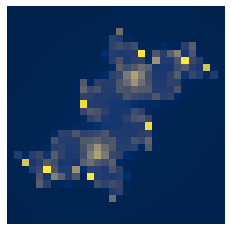

In [7]:
plt.axis('off')
plt.imshow(J, cmap=cm.cividis);

This image is a direct representation of a 2D array. Sometimes this kind of plot is called a *heatmap*. We'll see many other types of plot later. **Exercise**: do the dark pixels represent large values, or small ones? Which pixels represent points which are escaping quickly?

As we have seen, implementing the Julia calculations using three nested for-loops is slow. 
**Exercise:** exactly what three for-loops are we talking about and how are they nested?

### Vectorising our code

Even though we were putting values into a Numpy array, we weren't taking advantage of Numpy vectorisation. In the next version we do so. 

In [8]:
c = -0.065 + 0.66j # Julia constant: using 'j'
def f(z): 
    return z**2 + c # complex arithmetic is built-in
def Julia(zmin, zmax, m, n, tmax=256):
    xs = np.linspace(zmin.real, zmax.real, n)
    ys = np.linspace(zmin.imag, zmax.imag, m)
    X, Y = np.meshgrid(xs, ys)
    Z = X + 1j * Y 
    J = np.ones(Z.shape) * tmax # initialise all points with max escape time
    for t in range(tmax):
        mask = np.abs(Z) <= 2.
        Z[mask] = f(Z[mask])
        J[~mask] -= 1 # decrement escape time of points which have escaped
    return J

We have used a handy function, `np.meshgrid`, to give us the x and y coordinates for all pixels. **Exercise**: check the shape and the values stored in `X`, `Y` and `Z`.

* `J` starts with value `tmax` everywhere
* set `mask` where $z$ has not escaped
* decrement `J` wherever $z$ has escaped
* mask runs `f` only where $z$ has not escaped

We have also used a *mask*, that is a Boolean array. It stores the locations where $z$ has not yet escaped. The mask enables us to run `f` only on such locations. We calculate `J` by decrementing the escape time of the *other* points using `~`, the logical `not` operator. The way to think of this is: all points start with escape time `tmax=256`. A point which escapes straight away will be decremented 256 times, so will end up with escape time 0, which is correct.

In [9]:
J = Julia(zmin, zmax, m=256, n=256) # much faster!

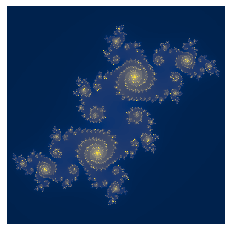

In [10]:
plt.axis('off')
plt.imshow(J, cmap=cm.cividis);

**Exercise**: try out different values of $c$ to see what happens. Zoom in by changing `zmin` and `zmax`. Try different colourmaps using `cmap`: see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html.

The Mandelbrot fractal is another famous one. This time $f(z) = z^2 + z_0$, which is implemented as follows.

In [11]:
def Mandelbrot(zmin, zmax, m, n, tmax=256):
    xs = np.linspace(zmin.real, zmax.real, n)
    ys = np.linspace(zmin.imag, zmax.imag, m)
    X, Y = np.meshgrid(xs, ys)
    Z = X + 1j * Y
    C = np.copy(Z)
    M = np.ones(Z.shape) * tmax
    for t in range(tmax):
        mask = np.abs(Z) <= 2.
        Z[ mask] = Z[mask]**2 + C[mask]
        M[~mask] -= 1.
    return M

In [12]:
zmin = -2.3 - 1.5j
zmax =  0.7 + 1.5j
M = Mandelbrot(zmin, zmax, 1024, 1024)

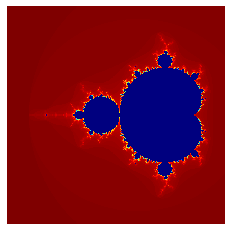

In [13]:
plt.axis('off')
plt.imshow(M, cmap=cm.jet_r);

### Where will we use this?

`meshgrid` is also useful for creating physical simulations, e.g. heat diffusion, water waves, agents in a grid, etc.

### Further reading

* Numberphile on Feigenbaum's constant (related to iterated functions in $\mathbb{R}$ instead of $\mathbb{C}$) and eventually mentions Julia/Mandelbrot fractals: https://www.youtube.com/watch?v=ETrYE4MdoLQ